# Data & Lib

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge,Lasso
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

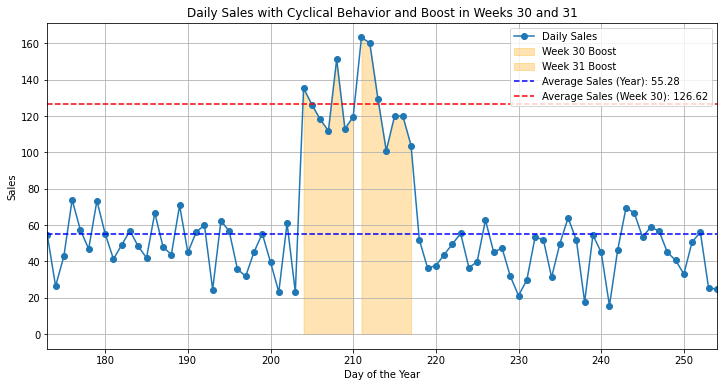

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Number of days
num_days = 365

# Generate day numbers
day_numbers = np.arange(1, num_days + 1)

# Generate a cyclic component with higher sales on weekends
cyclic_component = 10 * np.sin(2 * np.pi * day_numbers / 365)  # 1 cycle per year
weekend_effect = 10 * (np.sin(2 * np.pi * (day_numbers % 7) / 7) > 0.5)  # Higher sales on weekends

# Generate sales data: base value + cyclic component + weekend effect + random noise
sales_data = 50 + cyclic_component + weekend_effect + np.random.normal(0, 15, num_days)

# Ensure sales are always positive
sales_data = np.maximum(sales_data, 0)

# Calculate week number and day of the week
week_numbers = (day_numbers - 1) // 7 + 1
day_of_week = (day_numbers - 1) % 7

# Identify days within week 30 and week 40
boost_weeks = (week_numbers >= 30) & (week_numbers <= 31)
boost_amount = np.random.uniform(50, 100, np.sum(boost_weeks))
sales_data[boost_weeks] += boost_amount

# Create a DataFrame
df = pd.DataFrame({
    'Day': day_numbers,
    'Sales': sales_data,
    'Week_Number': week_numbers,
    'Day_of_the_Week': day_of_week
})

# Calculate average sales over the year and over weeks 30 and 40
average_sales_year = df['Sales'].mean()
average_sales_week_30 = df.loc[(week_numbers >= 30)&(week_numbers <= 31), 'Sales'].mean()


# Convert columns to numpy arrays
day_array = df['Day'].to_numpy()
sales_array = df['Sales'].to_numpy()

# Identify and highlight weeks 30 and 40
highlight_days = (week_numbers >= 30) & (week_numbers <= 31)
highlight_days_filtered = df[highlight_days]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(day_array, sales_array, marker='o', label='Daily Sales')

# Highlight weeks 30 and 40
for week in [30, 31]:
    week_start = (week - 1) * 7 + 1
    week_end = week * 7
    plt.fill_between(df['Day'], df['Sales'], where=(df['Week_Number'] == week), color='orange', alpha=0.3, label=f'Week {week} Boost')

# Add horizontal lines for averages
plt.axhline(y=average_sales_year, color='blue', linestyle='--', label=f'Average Sales (Year): {average_sales_year:.2f}')
plt.axhline(y=average_sales_week_30, color='red', linestyle='--', label=f'Average Sales (Week 30): {average_sales_week_30:.2f}')


# Zoom in on weeks 30 and 40 range
plt.xlim([29 * 7-30, 32 * 7+30])  # Adjust as needed

plt.title('Daily Sales with Cyclical Behavior and Boost in Weeks 30 and 31')
plt.xlabel('Day of the Year')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.show()


<Figure size 864x432 with 0 Axes>

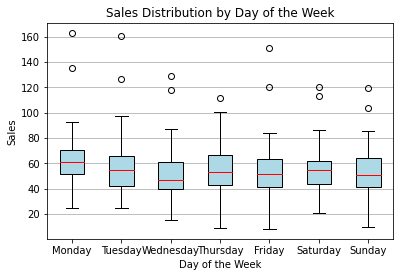

In [4]:
#Plot the box plot for sales over each day of the week
plt.figure(figsize=(12, 6))
df.boxplot(column='Sales', by='Day_of_the_Week', grid=False, patch_artist=True, 
           boxprops=dict(facecolor='lightblue', color='black'), 
           medianprops=dict(color='red'), 
           whiskerprops=dict(color='black'))

# Customize the plot
plt.title('Sales Distribution by Day of the Week')
plt.suptitle('')  # Suppress the automatic title to avoid overlap with the main title
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.xticks(ticks=np.arange(1, 8), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(axis='y')
plt.show()

## Encoding week using sin/cos instead of one-hot encoding

matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


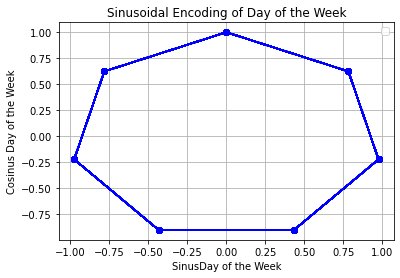

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Number of days in a week
days_of_week = np.arange(7)  # Correctly define an array from 0 to 6

# Assuming df is already defined and contains 'Day_of_the_Week' column
df['Day_of_the_Week_Sin'] = df['Day_of_the_Week'].apply(lambda x : np.sin(2 * np.pi * x / 7))
df['Day_of_the_Week_Cos'] = df['Day_of_the_Week'].apply(lambda x : np.cos(2 * np.pi * x / 7))

sin_array = df['Day_of_the_Week_Sin'].to_numpy()
cos_array = df['Day_of_the_Week_Cos'].to_numpy()


# Plot sine encoding

plt.plot(sin_array, cos_array, marker='o', color='blue', linestyle='-')

plt.xlabel('SinusDay of the Week')
plt.ylabel('Cosinus Day of the Week')
plt.title('Sinusoidal Encoding of Day of the Week')
plt.grid(True)
plt.legend()




In [6]:
df

,Day,Sales,Week_Number,Day_of_the_Week,Day_of_the_Week_Sin,Day_of_the_Week_Cos
0,1,54.365447,1,0,0.000000,1.000000
1,2,42.961018,1,1,0.781831,0.623490
2,3,67.091426,1,2,0.974928,-0.222521
3,4,71.506681,1,3,0.433884,-0.900969
4,5,37.795243,1,4,-0.433884,-0.900969
...,...,...,...,...,...,...
360,361,41.227466,52,3,0.433884,-0.900969
361,362,73.460506,52,4,-0.433884,-0.900969
362,363,35.610350,52,5,-0.974928,-0.222521
363,364,68.862971,52,6,-0.781831,0.623490


# Forecaster

In [13]:


# Split data into train, backtest, and future sets
train_size = 27
train_series = df.loc[df['Week_Number']<=27,'Sales']   # Weeks 1-27
backtest_series = df.loc[(df['Week_Number']>=27)&(df['Week_Number']<=29),'Sales']  # Weeks 28-29 (for backtesting)
future_series = df.loc[(df['Week_Number']>=30)&(df['Week_Number']<=31),'Sales']          # Weeks 30-31 (for prediction)

train_exog = df.loc[df['Week_Number']<=27,['Day_of_the_Week_Sin','Day_of_the_Week_Cos']]
backtest_exog = df.loc[(df['Week_Number']>=27)&(df['Week_Number']<=29),['Day_of_the_Week_Sin','Day_of_the_Week_Cos']]
future_exog = df.loc[(df['Week_Number']>=30)&(df['Week_Number']<=31),['Day_of_the_Week_Sin','Day_of_the_Week_Cos']]

# Define the forecaster for autoregressive Ridge regression
forecaster = ForecasterAutoreg(
    regressor=Ridge(),
    lags=5  # This value will be tuned in the grid search
)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength for Ridge
}

lags_grid = {
    'lags': [3, 5, 7]  # Different lag values to be tested
}

# Perform grid search for hyperparameter tuning
results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=train_series,
    exog=train_exog,
    param_grid=param_grid,
    lags_grid = lags_grid,
    steps=1,  # Steps for backtesting (weeks 28 and 29)
    metric='mean_squared_error',
    initial_train_size=10,  # Use all training data (weeks 1-27)
    fixed_train_size=False,
    return_best=True,
    verbose=True
)

# Display the best parameters
print("Best parameters found:")
print(results_grid)

# Fit the model on the full training data with the best parameters
forecaster.fit(y=train_series, exog=train_exog)

# Backtest: Predict for weeks 28 and 29, then compare with actual values
backtest_pred = forecaster.predict(steps=2, exog=backtest_exog)

# Calculate backtest error
backtest_error = mean_squared_error(backtest_series, backtest_pred)
print(f"Backtest Predictions (weeks 28-29): {backtest_pred}")
print(f"Backtest Mean Squared Error: {backtest_error}")

# Predict for weeks 30 and 31 (out-of-sample forecast)
future_pred = forecaster.predict(steps=2, exog=future_exog)

# Display predictions for weeks 30 and 31
print(f"Predictions for weeks 30-31: {future_pred}")

Number of models compared: 4.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:1260: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/navidmohamadi/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:1260: UserWarning: `exog` has no DatetimeInd

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 179
    Number of folds: 179
    Number skipped folds: 0 
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   0 -- 9  (n=10)
    Validation: 10 -- 10  (n=1)
Fold: 1
    Training:   No training in this fold
    Validation: 11 -- 11  (n=1)
Fold: 2
    Training:   No training in this fold
    Validation: 12 -- 12  (n=1)
Fold: 3
    Training:   No training in this fold
    Validation: 13 -- 13  (n=1)
Fold: 4
    Training:   No training in this fold
    Validation: 14 -- 14  (n=1)
Fold: 5
    Training:   No training in this fold
    Validation: 15 -- 15  (n=1)
Fold: 6
    Training:   No training in this fold
    Validation: 16 -- 16  (n=1)
Fold: 7
    Training:   No training in this fold
    Validation: 17 -- 17  (n=1)
Fold: 8
    Training

TypeError: Argument `index` must be a pandas DatetimeIndex or RangeIndex.